In [3]:
import quandl as ql
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

In [4]:
import seaborn as sns
sns.set_theme()

In [5]:

from sklearn.preprocessing import StandardScaler
from sklearn.base import clone
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.model_selection import cross_val_score,GridSearchCV
from sklearn.dummy import DummyClassifier

In [6]:
import joblib

In [7]:
IMAGES_PATH = Path() / "images" 
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## Load Data

In [1]:
def load_data(batch="train"):
    with pd.HDFStore('data.h5') as store:
        data = store['model_data/portfolio/{}'.format(batch)]
    return data
    

In [8]:
train_set = load_data("train")

In [9]:
test_set = load_data("test")

In [10]:
train_set.shape

(14317, 31)

In [11]:
test_set.shape

(4152, 31)

# Select investment Universe

In [25]:
#train_set = train_set[train_set.dollar_vol_rank < 10]

## Create Model data

In [82]:
def model_data(data):
    
    OHLCV = ['open', 'close', 'low', 'high', 'volume']
    X = data.drop(OHLCV, axis=1)
    X = X.drop(['dollar_vol', 'dollar_vol_rank'], axis=1)
    X = X.drop([c for c in data.columns if 'year' in c or 'lag' in c], axis=1)
    y = pd.DataFrame.copy(data.filter(like='target'))
    X = X.drop(y.columns, axis=1)
    y['direction'] = (y['target_1d'] > 0).astype(int)
    
    return X,y

In [83]:
X_train,y_train = model_data(train_set)
X_test, y_test = model_data(test_set)

In [84]:
print("X_train: {}, y_train: {}".format(X_train.shape, y_train.shape))
print("X_test: {}, y_test: {}".format(X_test.shape, y_test.shape))

X_train: (14317, 23), y_train: (14317, 2)
X_test: (4152, 23), y_test: (4152, 2)


In [85]:
horizon = 1 #set prediction horizon

target = 'target_{}d'.format(horizon)

In [86]:
year = 500 # there are roughly 252 trading day in a year
test_period_size = 10
n_splits = 2

In [87]:
y_train.head()

target_1d  direction
ticker Date                            
AAL    2010-04-06  -0.037414          0
       2010-04-07   0.101688          1
       2010-04-08  -0.030937          0
       2010-04-09   0.040166          1
       2010-04-12  -0.017208          0

In [88]:
tsplit = TimeSeriesSplit(n_splits=n_splits,
                         max_train_size=year,
                         test_size=test_period_size,
                         gap=1)

In [89]:
scores = {}

In [90]:

#for fold, (train_idx, val_idx) in enumerate(tsplit.split(X_train)):
    #print(fold, train_idx, val_idx)

In [91]:
def param_compare(grid):
    results_df = pd.DataFrame(grid.cv_results_)
    results_df = results_df.sort_values(by=["rank_test_score"])
    results_df = results_df.set_index(results_df["params"]
                                      .apply(lambda x: "_".join(str(val) for val in x.values())))
    return results_df[["params", "rank_test_score", "mean_test_score", "std_test_score"]]

In [92]:
X_train.columns

Index(['dollar_vol_1m', 'SMA_5', 'SMA_21', 'SMA_63', 'return_1d', 'return_5d',
       'return_10d', 'return_21d', 'return_42d', 'return_63d', 'HT_TRENDLINE',
       'bb_high', 'bb_low', 'rsi', 'macd', 'PLUS_DM', 'MINUS_DM', 'ADX', 'PPO',
       'STOCH', 'MFI', 'AD', 'atr'],
      dtype='object')

In [93]:
y_train.columns

Index(['target_1d', 'direction'], dtype='object')

## Model : Dummy classifier

In [94]:
dummy_clf = DummyClassifier(strategy="most_frequent")

In [95]:
dummy_scores = cross_val_score(dummy_clf, X_train, y_train.direction, cv=tsplit, scoring="accuracy")
np.average(dummy_scores)

0.7

In [96]:
dummy_clf.fit(X_train, y_train.direction)

DummyClassifier(strategy='most_frequent')

In [97]:
scores.update({"dummy_clf": dummy_scores})

In [98]:
y_pred_dummy = dummy_clf.predict(X_test)

In [99]:
accuracy_score(y_pred_dummy, y_test.direction)

0.4987957610789981

## Model : Logistic Regression

In [100]:
log_clf = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))

In [101]:
log_clf_scores = cross_val_score(log_clf, X_train,
                         y_train.direction,cv=tsplit,
                         scoring='accuracy')

In [102]:
np.average(log_clf_scores)

0.30000000000000004

In [103]:
scores.update({'log_clf':log_clf_scores})

In [104]:
log_params = { 'logisticregression__C' : np.logspace(-5,5,11), 
              'logisticregression__solver': ['liblinear', 'saga'], 
              'logisticregression__penalty' : ['l1', 'l2']}

In [105]:
log_grid = GridSearchCV(log_clf, param_grid= log_params, scoring='accuracy', cv=tsplit, n_jobs = -1)

In [106]:
log_grid.fit(X_train, y_train.direction)

/home/ashishk/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ashishk/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ashishk/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ashishk/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ashishk/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ashishk/anacon

GridSearchCV(cv=TimeSeriesSplit(gap=1, max_train_size=500, n_splits=2, test_size=10),
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('logisticregression',
                                        LogisticRegression(max_iter=1000))]),
             n_jobs=-1,
             param_grid={'logisticregression__C': array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02,
       1.e+03, 1.e+04, 1.e+05]),
                         'logisticregression__penalty': ['l1', 'l2'],
                         'logisticregression__solver': ['liblinear', 'saga']},
             scoring='accuracy')

In [107]:
log_grid.best_estimator_

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=1e-05, max_iter=1000, penalty='l1',
                                    solver='saga'))])

In [108]:
y_pred_log = log_grid.best_estimator_.predict(X_test)

In [109]:
log_clf = clone(log_grid.best_estimator_)
log_clf.fit(X_train, y_train.direction)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=1e-05, max_iter=1000, penalty='l1',
                                    solver='saga'))])

In [110]:
y_pred_log = log_clf.predict(X_test)

In [111]:
accuracy_score(y_test.direction, y_pred_log)

0.4987957610789981

In [112]:
(y_test.direction == y_pred_log).value_counts()

False    2081
True     2071
Name: direction, dtype: int64

In [113]:
joblib.dump(log_grid.best_estimator_, "log_clf_p.pkl")

['log_clf_p.pkl']

In [114]:
tmp = joblib.load("log_clf.pkl")

## Model : Support Vector Machine

In [115]:
from sklearn.svm import SVC,LinearSVC

In [116]:
svm_clf = make_pipeline(StandardScaler(), SVC())

In [117]:
svm_clf_scores = cross_val_score(svm_clf, X_train,
                         y_train.direction,cv=tsplit,
                         scoring='accuracy')

In [118]:
np.average(svm_clf_scores)

0.7

In [119]:
scores.update({'svm_clf': svm_clf_scores})

In [120]:
svc_params = {
    'svc__C': np.logspace(-5,5,11),
    'svc__gamma': [0.1,1,10,100],
}

In [121]:
svc_grid = GridSearchCV(svm_clf, param_grid=svc_params, scoring='accuracy', cv=tsplit, n_jobs = -1)

In [122]:
svc_grid.fit(X_train, y_train.direction)

GridSearchCV(cv=TimeSeriesSplit(gap=1, max_train_size=500, n_splits=2, test_size=10),
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('svc', SVC())]),
             n_jobs=-1,
             param_grid={'svc__C': array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02,
       1.e+03, 1.e+04, 1.e+05]),
                         'svc__gamma': [0.1, 1, 10, 100]},
             scoring='accuracy')

In [123]:
y_pred_svm = svc_grid.best_estimator_.predict(X_test)

In [124]:
accuracy_score(y_test.direction, y_pred_svm)

0.4987957610789981

## Model : Random forest

In [125]:
from sklearn.ensemble import RandomForestClassifier

In [126]:
rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16,
                                n_jobs = -1)

In [127]:
rnd_clf_scores = cross_val_score(rnd_clf, X_train, y_train.direction, cv=tsplit, scoring="accuracy")


In [128]:
np.average(rnd_clf_scores)

0.30000000000000004

In [129]:
scores.update({'rnd_clf': rnd_clf_scores})

In [130]:
rf_params = [
    {'n_estimators': [10, 50,100,200], 
     'max_features': [5, 10, 20], 
 'max_depth': [10,20,30], 
     'bootstrap': [True, False]}
]



In [131]:
rf_grid = GridSearchCV(rnd_clf, param_grid=rf_params, scoring='accuracy', cv=tsplit, n_jobs= -1)

In [132]:
rf_grid.fit(X_train,y_train.direction)

GridSearchCV(cv=TimeSeriesSplit(gap=1, max_train_size=500, n_splits=2, test_size=10),
             estimator=RandomForestClassifier(max_leaf_nodes=16,
                                              n_estimators=500, n_jobs=-1),
             n_jobs=-1,
             param_grid=[{'bootstrap': [True, False], 'max_depth': [10, 20, 30],
                          'max_features': [5, 10, 20],
                          'n_estimators': [10, 50, 100, 200]}],
             scoring='accuracy')

In [133]:
y_pred_rf = rf_grid.best_estimator_.predict(X_test)

In [134]:
accuracy_score(y_test.direction, y_pred_rf)

0.5048169556840078

In [135]:
for name, score in zip(X_test.columns,rf_grid.best_estimator_.feature_importances_):
    print(name, score)

dollar_vol_1m 0.07705397696073975
SMA_5 0.023965860005943532
SMA_21 0.023823515291637527
SMA_63 0.024745641499498715
return_1d 0.03832388673226756
return_5d 0.03778392244477369
return_10d 0.038074916293368045
return_21d 0.053072837219337116
return_42d 0.033283173910305996
return_63d 0.03442900743479946
HT_TRENDLINE 0.02157475937503364
bb_high 0.046808719547502015
bb_low 0.03912197941669061
rsi 0.046128823696896464
macd 0.02914005577798722
PLUS_DM 0.03250054910801092
MINUS_DM 0.04050596115705699
ADX 0.03683230487981859
PPO 0.04636039673410968
STOCH 0.04806981367737212
MFI 0.04487573962893541
AD 0.09858565478506137
atr 0.08493850442285374


## Model : Neural Network

In [136]:
from sklearn.neural_network import MLPClassifier

In [137]:
mlp_clf = MLPClassifier(hidden_layer_sizes=(50,50,50), max_iter=1000, random_state=42)

In [138]:
neural_clf = make_pipeline(StandardScaler(), mlp_clf)

In [139]:
neural_scores = cross_val_score(neural_clf, X_train, y_train.direction, cv=tsplit, scoring='accuracy')

In [140]:
scores.update({'nn_clf': neural_scores})

In [141]:
neural_scores

array([0.4, 0.2])

In [142]:
np.average(neural_scores)

0.30000000000000004

In [143]:
neural_params = {
    'mlpclassifier__activation' : ['logistic', 'tanh', 'relu'],
    'mlpclassifier__alpha' : [0.001,0.01,0.1,10],
}

In [144]:
neural_grid = GridSearchCV(neural_clf, param_grid=neural_params, cv=tsplit, scoring='accuracy', n_jobs = -1)

In [145]:
neural_grid.fit(X_train,y_train.direction)

/home/ashishk/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


GridSearchCV(cv=TimeSeriesSplit(gap=1, max_train_size=500, n_splits=2, test_size=10),
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('mlpclassifier',
                                        MLPClassifier(hidden_layer_sizes=(50,
                                                                          50,
                                                                          50),
                                                      max_iter=1000,
                                                      random_state=42))]),
             n_jobs=-1,
             param_grid={'mlpclassifier__activation': ['logistic', 'tanh',
                                                       'relu'],
                         'mlpclassifier__alpha': [0.001, 0.01, 0.1, 10]},
             scoring='accuracy')

In [146]:
neural_grid.best_estimator_

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('mlpclassifier',
                 MLPClassifier(activation='logistic', alpha=0.001,
                               hidden_layer_sizes=(50, 50, 50), max_iter=1000,
                               random_state=42))])

In [147]:
neural_grid.best_score_

0.7

In [148]:
y_pred_nn = neural_grid.best_estimator_.predict(X_test)

In [149]:
accuracy_score(y_test.direction, y_pred_nn)

0.5077071290944123

## Ensemble

- voting classifier

In [150]:
from sklearn.ensemble import VotingClassifier

In [151]:
voting_clf = VotingClassifier(estimators=[('lr', clone(log_grid.best_estimator_)),
                                          ('rf', clone(rf_grid.best_estimator_)),
                                         ('sv', clone(svc_grid.best_estimator_)),
                                         ('nn', clone(neural_grid.best_estimator_))],
                             voting='hard')

In [152]:
voting_scores = cross_val_score(voting_clf, X_train, y_train.direction, cv=tsplit, scoring='accuracy')

In [153]:
scores.update({'voting_clf': voting_scores})

In [154]:
voting_clf.fit(X_train, y_train.direction)

VotingClassifier(estimators=[('lr',
                              Pipeline(steps=[('standardscaler',
                                               StandardScaler()),
                                              ('logisticregression',
                                               LogisticRegression(C=1e-05,
                                                                  max_iter=1000,
                                                                  penalty='l1',
                                                                  solver='saga'))])),
                             ('rf',
                              RandomForestClassifier(max_depth=30,
                                                     max_features=10,
                                                     max_leaf_nodes=16,
                                                     n_estimators=50,
                                                     n_jobs=-1)),
                             ('sv',
                              Pipeline(steps=[('standardscaler',
                                               StandardScaler()),
                                              ('svc',
                                               SVC(C=1e-05, gamma=0.1))])),
                             ('nn',
                              Pipeline(steps=[('standardscaler',
                                               StandardScaler()),
                                              ('mlpclassifier',
                                               MLPClassifier(activation='logistic',
                                                             alpha=0.001,
                                                             hidden_layer_sizes=(50,
                                                                                 50,
                                                                                 50),
                                                             max_iter=1000,
                                                             random_state=42))]))])

In [155]:
y_pred_vote = voting_clf.predict(X_test)

In [156]:
accuracy_score(y_test.direction, y_pred_vote)

0.49975915221579964

### Adaptive Boosting

In [157]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

In [158]:
ada_clf = AdaBoostClassifier()

In [159]:
ada_scores = cross_val_score(ada_clf, X_train, y_train.direction, scoring='accuracy', cv=tsplit)

In [160]:
scores.update({'adaboost': ada_scores})

In [161]:
np.average(ada_scores)

0.55

In [162]:
ada_params = {
    #'estimator__max_depth': [5,10,15,20],
    #'estimator__max_features': [2,5,10,20],
    #'max_leaf_nodes': [2,4,8,16,24],
    'learning_rate': [0.01,0.1,0.2,0.5,1],
    'n_estimators': [10,20,40,100,150,200,500]
}

In [163]:
ada_grid = GridSearchCV(ada_clf,param_grid=ada_params,
                       cv=tsplit, scoring='accuracy', n_jobs=-1)

In [164]:
ada_grid.fit(X_train, y_train.direction)

GridSearchCV(cv=TimeSeriesSplit(gap=1, max_train_size=500, n_splits=2, test_size=10),
             estimator=AdaBoostClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.2, 0.5, 1],
                         'n_estimators': [10, 20, 40, 100, 150, 200, 500]},
             scoring='accuracy')

In [165]:
y_pred_ada = ada_grid.best_estimator_.predict(X_test)

In [166]:
accuracy_score(y_pred_ada, y_test.direction)

0.5055394990366089

### Gradient Boosting

In [167]:
from sklearn.ensemble import GradientBoostingClassifier

In [168]:
from xgboost import XGBClassifier

In [169]:
grb_clf = GradientBoostingClassifier()

In [170]:
grb_scores = cross_val_score(grb_clf, X_train,
                             y_train.direction,
                            scoring= 'accuracy',
                            cv=tsplit)

In [171]:
scores.update({'gradboost': grb_scores})

In [172]:
np.average(grb_scores)

0.7

In [173]:
grb_params = {
    "max_depth" : [2,4,8,16,20],
    "n_estimators": [1,2,4,8,16,32,64,128,200],
    "learning_rate": [0.01,0.2,0.5,0.1,1,10],
}

In [174]:
grb_grid = GridSearchCV(grb_clf, param_grid=grb_params,
                       cv=tsplit,
                       scoring="accuracy", n_jobs=-1)

In [175]:
grb_grid.fit(X_train, y_train.direction)

GridSearchCV(cv=TimeSeriesSplit(gap=1, max_train_size=500, n_splits=2, test_size=10),
             estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.2, 0.5, 0.1, 1, 10],
                         'max_depth': [2, 4, 8, 16, 20],
                         'n_estimators': [1, 2, 4, 8, 16, 32, 64, 128, 200]},
             scoring='accuracy')

In [176]:
y_pred_grb = grb_grid.best_estimator_.predict(X_test)

In [177]:
accuracy_score(y_test.direction, y_pred_grb)

0.5069845857418112

## preserve model statistics and final results

In [178]:
lg_clf = log_grid.best_estimator_
sv_clf = svc_grid.best_estimator_
rf_clf = rf_grid.best_estimator_
n_clf = neural_grid.best_estimator_
adaboost = ada_grid.best_estimator_
grbboost = grb_grid.best_estimator_

In [179]:
models = {'log_clf': lg_clf,
          'svm_clf': sv_clf,
          'rnd_clf': rf_clf,
          'mlp_clf': n_clf,
          'vot_clf':voting_clf,
          'ada_clf': adaboost,
          'grb_clf': grbboost,
          'dummy_clf': dummy_clf}

In [180]:
X_test.columns

Index(['dollar_vol_1m', 'SMA_5', 'SMA_21', 'SMA_63', 'return_1d', 'return_5d',
       'return_10d', 'return_21d', 'return_42d', 'return_63d', 'HT_TRENDLINE',
       'bb_high', 'bb_low', 'rsi', 'macd', 'PLUS_DM', 'MINUS_DM', 'ADX', 'PPO',
       'STOCH', 'MFI', 'AD', 'atr'],
      dtype='object')

In [183]:
def save_results(test_set, X_test, models):
    
    test_results = test_set.loc[X_test.index]
    for model in  models.keys():
        #test_set[model] = model.predict(X_test)
        test_results[model] = test_results['target_1d'] * models[model].predict(X_test)
    test_results.to_hdf('data.h5', 'models/test_result/portfolio')
    return test_results

In [184]:
test_results = save_results(test_set,X_test,models)

## Comparison of strategies

### 1. comparing returns

In [ ]:
train_set.dro

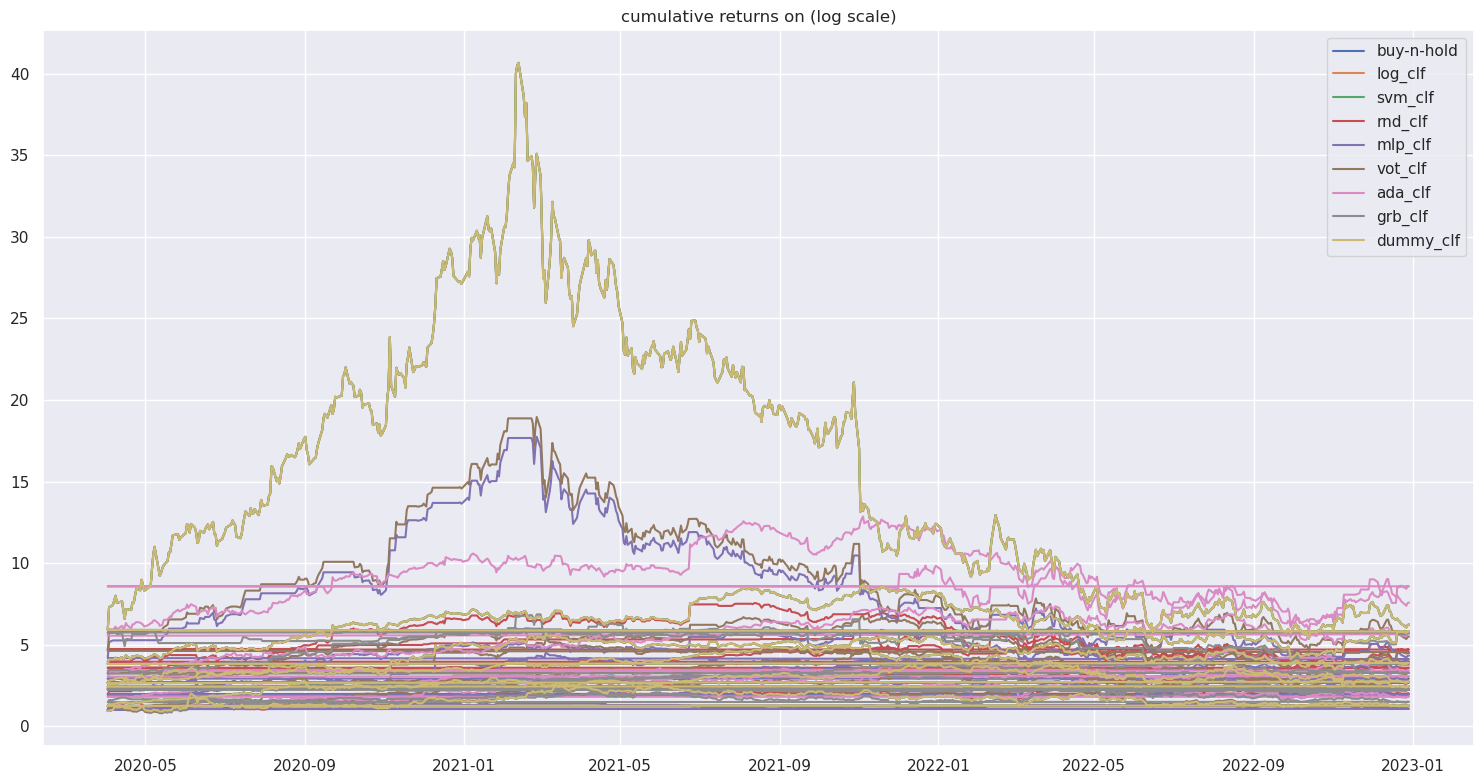

In [198]:
fig,ax = plt.subplots(figsize=(15,8))

plt.plot(test_results[[target]].cumsum().apply(np.exp).droplevel(0), label='buy-n-hold')
for model in models.keys():
    plt.plot(test_results[[model]].cumsum().apply(np.exp).droplevel(0), label = model)
plt.legend()
plt.title('cumulative returns on (log scale)')
save_fig("returns_portfolio")
plt.show()

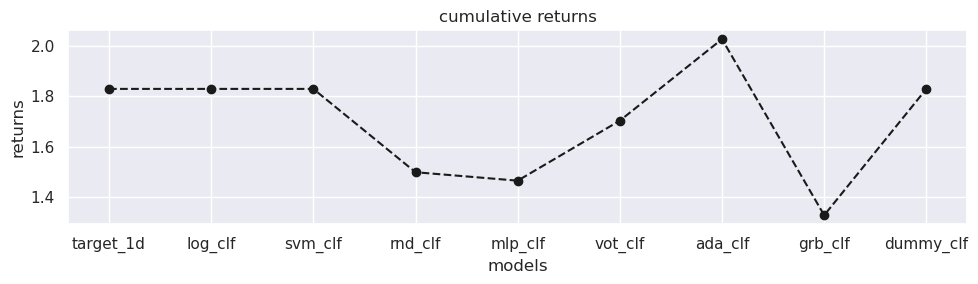

In [200]:
cum_returns = test_results[[target] + list(models.keys())].sum()
fig,ax = plt.subplots(figsize=(10,3))
ax.plot(cum_returns, 'ko--',)
#ax.set_yticks(np.arange(0,.8,0.1))
plt.title("cumulative returns")
plt.xlabel('models')
plt.ylabel('returns')
save_fig("returns_dist")
plt.show()

### 2. comparing models

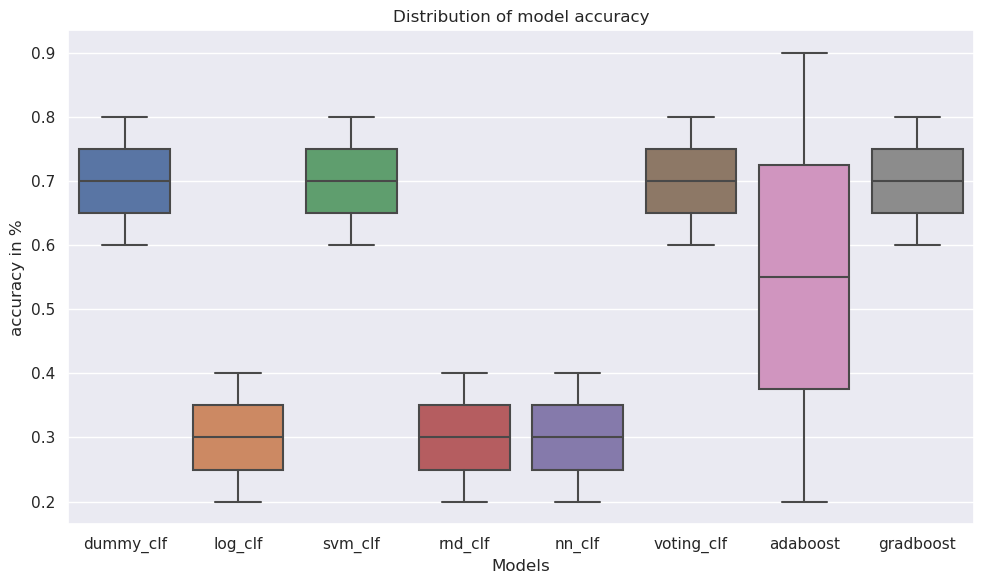

In [201]:
fig,ax = plt.subplots(figsize=(10,6))
sns.boxplot(data=pd.DataFrame(scores), ax = ax)
plt.title('Distribution of model accuracy')
ax.set_xlabel("Models")
ax.set_ylabel("accuracy in %")
#plt.legend()
save_fig("accuracy_valid")
plt.show()

In [202]:
accuracy_test = {}
for model in models.keys():
    accuracy_test.update({model: accuracy_score(y_test.direction,models[model].predict(X_test))})
    

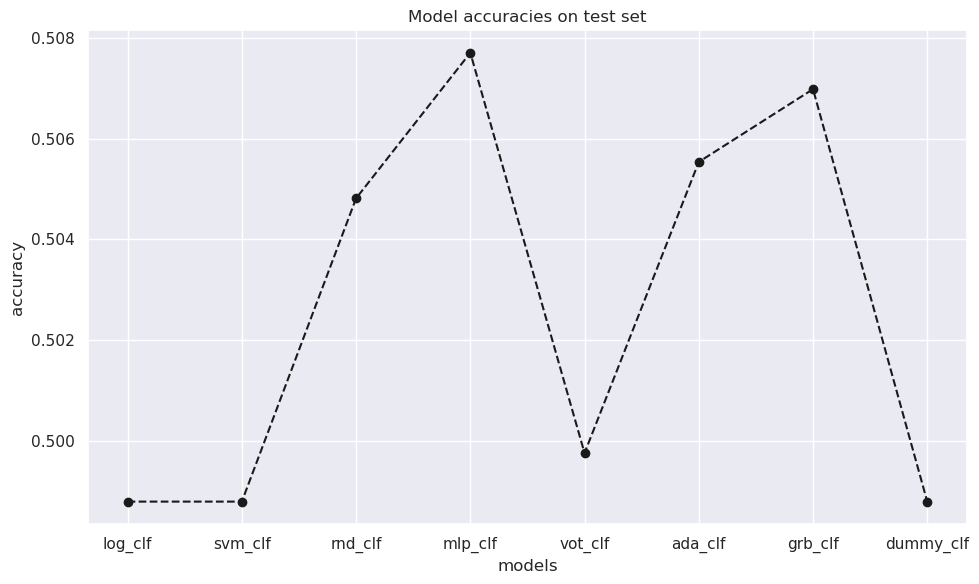

In [204]:
fig,ax = plt.subplots(figsize=(10,6))
ax.plot(pd.Series(accuracy_test), 'ko--',)
#ax.set_yticks(np.arange(0,.8,0.1))
plt.title("Model accuracies on test set")
plt.xlabel('models')
plt.ylabel('accuracy')
save_fig("accuracy_dist")
plt.show()